# Classify Solid and Liquid phases with Neural Network

Author: Weikai Qi
Email : wikaiqi@gmail.com

In this project, I will train a neural network to regonize 2D solid and liquid phases from configurations obtained from MD simulation data. We have trained a shallow neural network. Now I will use tensoeflow to bulid a deep neural network. **The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> sigmoid.

## data
Training set - The MD simulation generates 4500 liquid configurations with packing fraction [0.5, 0.68] and 6000 solid configurations packing fraction [0.74, 0.89]. I used those 10500 configruations as traning set. There are $64*64*2$ coordinates in In each configuraiton. I normalized the data by the box size and ensure the data in the range [-0.5, 0.5].  

Testing set - I run another simulation to generates 900 liquid configuraitons and 1200 solid configurations as the testing set. 

## 1- Load and shuffle Data

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt
import seaborn as sns
import gc
import time
import tensorflow as tf
from tensorflow.python.framework import ops
import math
%matplotlib inline

plt.rcParams["figure.figsize"]=(12, 10)
size = 64*64

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def load_data(filename, size, label_type='solid'):
    '''
    Load coordinates data from file, and combine the x, y cooredates into one row
    filename   -- the file which stores the coordinates
    size       -- size of each configuration (number of particles)
    label_type -- solid/liquid 
    
    '''
    data_df   = pd.read_csv(filename, engine='c')
    n_data    = int(data_df.shape[0]/size)
    
    data_x   = np.array(data_df['x'][:]).reshape(n_data, size)
    data_y   = np.array(data_df['y'][:]).reshape(n_data, size)
    
    dataSet_Feature = np.hstack((data_x, data_y))
    
    
    if label_type == 'solid' or label_type=='Solid' or label_type=='S':
        dataSet_Label = np.ones(n_data)
    elif label_type == 'liquid' or label_type=='Liquid' or label_type == 'L':
        dataSet_Label = np.zeros((n_data))
        
    dataSet = np.c_[dataSet_Feature, dataSet_Label]

    
    return dataSet
    

In [3]:
# Load solid/liquid training data 
solidTrainSet  = np.array(load_data("data/SaveConfigSolid.dat",  size, label_type='S'))
liquidTrainSet = np.array(load_data("data/SaveConfigLiquid.dat", size, label_type='L'))


trainSet  = np.r_[solidTrainSet, liquidTrainSet]

# shuffle dataSet
np.random.seed(1)
np.random.shuffle(trainSet)


train_x = trainSet[:, 0: 2*size].T 
train_y = trainSet[:, -1]
train_y = train_y.reshape(train_y.shape[0], 1).T

print("number of training samples : ", train_y.shape[1])
print("number of liquid training samples : ", solidTrainSet.shape[0])
print("number of solid  training samples : ", liquidTrainSet.shape[0])

number of training samples :  10500
number of liquid training samples :  4500
number of solid  training samples :  6000


In [4]:
def plot_rxy(data_Feature, data_Label, id, size):
    rx = data_Feature[0:size, id].T
    ry = data_Feature[size:2*size, id].T
    if bool(data_Label[0, id]):
        plt.plot(rx, ry, 'bo')
    else:
        plt.plot(rx, ry, 'ro')
    plt.axis([-0.5, 0.5, -0.5, 0.5])

Is this a solid phase?  True


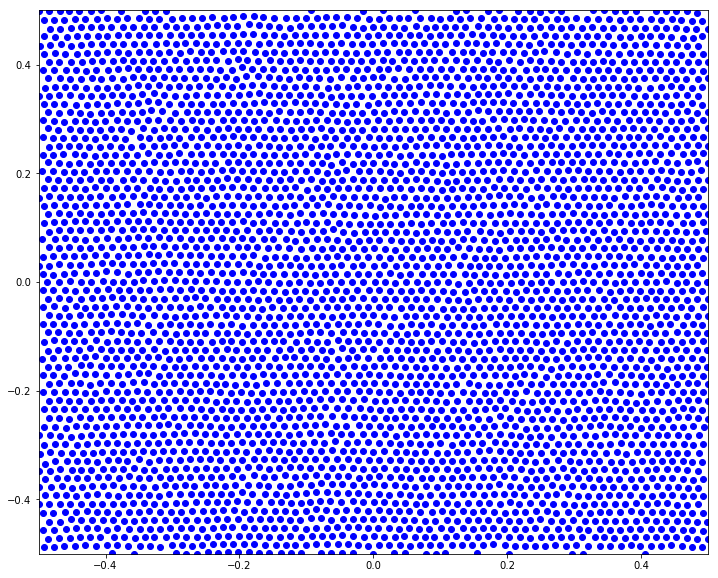

In [5]:
# plot configuration
id = 10000
plot_rxy(train_x, train_y, id, size)

print("Is this a solid phase? ", bool(train_y[0, id]))

Is this a solid phase?  False


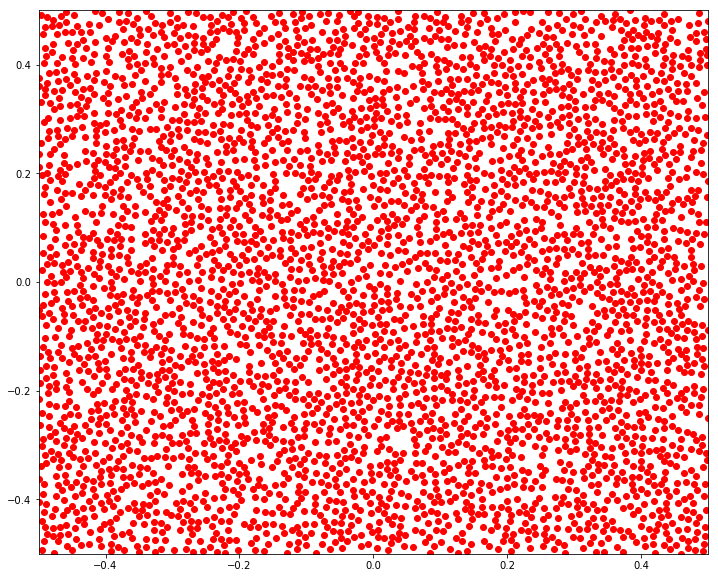

In [6]:
# plot configuration
id = 20
plot_rxy(train_x, train_y, id, size)

print("Is this a solid phase? ", bool(train_y[0, id]))

In [7]:
# Load solid/liquid test data 
solidTestSet  = np.array(load_data("data/SaveConfigSolidTest.dat",  size, label_type='S'))
liquidTestSet = np.array(load_data("data/SaveConfigLiquidTest.dat", size, label_type='L'))

testSet  = np.r_[solidTestSet, liquidTestSet]


test_x = testSet[:, 0: 2*size].T 
test_y = testSet[:, -1]
test_y = test_y.reshape(test_y.shape[0], 1).T

print("number of test samples : ", test_y.shape[1])
print("number of liquid test samples : ", solidTestSet.shape[0])
print("number of solid  test samples : ", liquidTestSet.shape[0])

number of test samples :  2100
number of liquid test samples :  900
number of solid  test samples :  1200


## 2 - Neural Network part -- TensorFlow

**The model** is *LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> sigmoid.


In [8]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session
    """
    X = tf.placeholder(dtype=tf.float32, shape=[n_x, None])
    Y = tf.placeholder(dtype=tf.float32, shape=[n_y, None])
    
    return X, Y

In [9]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. 
    """
    tf.set_random_seed(1)   
        
    #use Xavier Initialization for weights and Zero Initialization for biases
    W1 = tf.get_variable("W1", [25,2*size], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [25,1],      initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25],     initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [12,1],      initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [1,12],      initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [1,1],       initializer = tf.zeros_initializer())

    parameters = {"W1": W1,"b1": b1,
                  "W2": W2,"b2": b2,
                  "W3": W3,"b3": b3}
    
    return parameters

In [10]:
def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    A1 = tf.nn.dropout(A1, keep_prob)                      # dropout
    
    Z2 = tf.add(tf.matmul(W2, A1),b2)                      # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    A2 = tf.nn.dropout(A2, keep_prob)                      # dropout
    Z3 = tf.add(tf.matmul(W3, A2),b3)                      # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [11]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [12]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    """
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = labels))
    
    return cost

## backpropagation

Adam optimizer :
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 200, minibatch_size = 50, KeepProb = 0.5, lambd = 0.01, print_cost = True):
    """
    Implements a three-layer tensorflow neural network
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)
    keep_prob = tf.placeholder("float")

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Loss function with L2 Regularization with decaying learning rate beta=0.5
    regularizers = tf.nn.l2_loss(parameters['W1']) + tf.nn.l2_loss(parameters['W2']) + \
                  tf.nn.l2_loss(parameters['W3']) 
    cost = tf.reduce_mean(cost + lambd * regularizers)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, keep_prob: 0.5})
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 20 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        return parameters

## training the data

Cost after epoch 0: 0.590994
Cost after epoch 20: 0.123909
Cost after epoch 40: 0.120459
Cost after epoch 60: 0.116177
Cost after epoch 80: 0.124441
Cost after epoch 100: 0.115402
Cost after epoch 120: 0.114538
Cost after epoch 140: 0.104199
Cost after epoch 160: 0.115353
Cost after epoch 180: 0.129940
Cost after epoch 200: 0.105393
Cost after epoch 220: 0.110347
Cost after epoch 240: 0.111922
Cost after epoch 260: 0.120241
Cost after epoch 280: 0.107818
Cost after epoch 300: 0.116181
Cost after epoch 320: 0.113637
Cost after epoch 340: 0.118873
Cost after epoch 360: 0.114603
Cost after epoch 380: 0.127543
Cost after epoch 400: 0.113120
Cost after epoch 420: 0.116449
Cost after epoch 440: 0.116079
Cost after epoch 460: 0.113680
Cost after epoch 480: 0.110067
Cost after epoch 500: 0.105850
Cost after epoch 520: 0.114346
Cost after epoch 540: 0.107170
Cost after epoch 560: 0.105659
Cost after epoch 580: 0.128067
Cost after epoch 600: 0.113580
Cost after epoch 620: 0.117697
Cost after epo

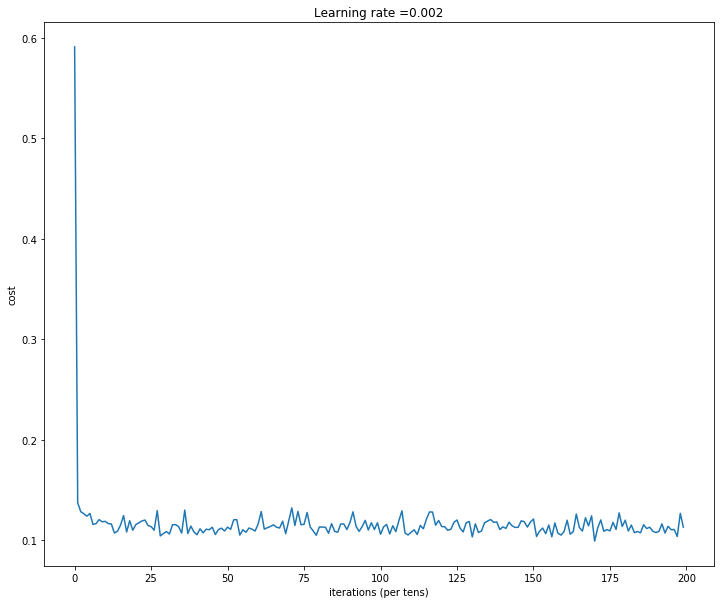

Parameters have been trained!


In [14]:
# Build a model with a n_h-dimensional hidden layer
parameters = model(train_x, train_y, test_x, test_y, learning_rate = 0.002,
          num_epochs = 1000, minibatch_size = 50, KeepProb=0.5, lambd=0.05, print_cost = True)

In [15]:
def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [16]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,"b1": b1,
              "W2": W2,"b2": b2,
              "W3": W3,"b3": b3}
    
    x = tf.placeholder("float", [8192, None])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.sigmoid(z3)
    
    sess = tf.Session()
    prob = sess.run(p, feed_dict = {x: X})
    prediction = (prob > 0.5)
        
    return prediction, prob

In [17]:
def get_accuracy(label, predicitions):
    return float((np.dot(label,predicitions.T) + np.dot(1-label,1-predicitions.T))/float(label.size))
        

In [18]:
prediction, prob = predict(test_x[:, :], parameters)
#print(prediction)

accuracy = get_accuracy(test_y, prediction)
print (('Accuracy: %d' % (accuracy*100)) + '%')


Accuracy: 100%


In [19]:
print(prob)

[[  9.95876431e-01   9.95893240e-01   9.95898426e-01 ...,   4.35916765e-04
    4.28064377e-04   3.62672348e-04]]


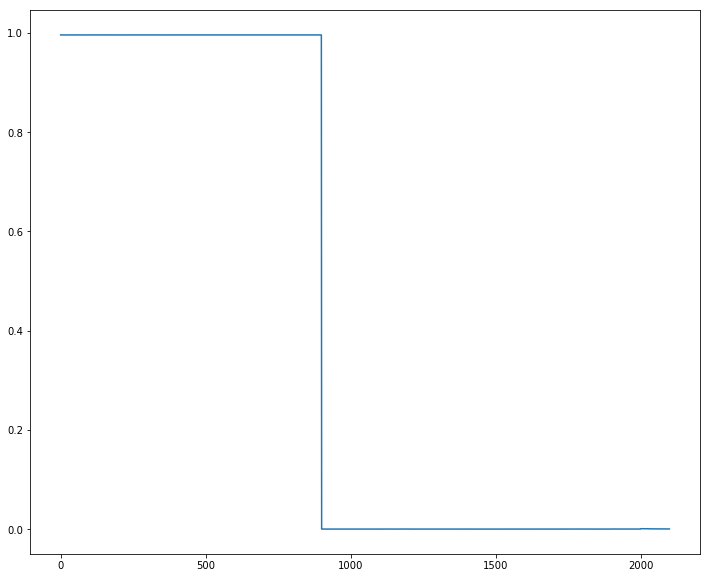

In [20]:
plt.plot(np.squeeze(prob))

In [35]:
def load_data2(filename, size):
    '''
    Load coordinates data from file, and combine the x, y cooredates into one row
    filename   -- the file which stores the coordinates
    size       -- size of each configuration (number of particles)
    label_type -- solid/liquid 
    
    '''
    data_df   = pd.read_csv(filename, engine='c', )
    n_data    = int(data_df.shape[0]/size)
    
    data_x   = np.array(data_df['x'][:]).reshape(n_data, size)
    data_y   = np.array(data_df['y'][:]).reshape(n_data, size)
    packf    = np.array(data_df['packf'][:]).reshape(n_data,size)
    #print(packf)
    
    dataSet = np.hstack((data_x, data_y, packf))
    
    return dataSet

[[-0.20353307 -0.06447682 -0.07328825 ...,  0.1         0.1         0.1       ]
 [-0.22230397 -0.08324038 -0.09001421 ...,  0.1         0.1         0.1       ]
 [-0.20456078 -0.08279804 -0.05982138 ...,  0.1         0.1         0.1       ]
 ..., 
 [-0.49933865 -0.48369426 -0.46829131 ...,  0.88        0.88        0.88      ]
 [ 0.49981816 -0.48428612 -0.46870901 ...,  0.88        0.88        0.88      ]
 [ 0.49998624 -0.48403304 -0.46846479 ...,  0.88        0.88        0.88      ]]


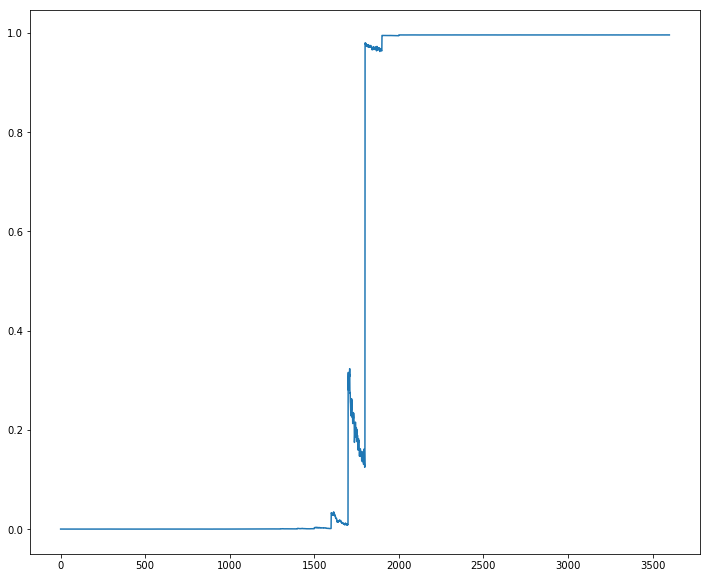

In [36]:
# Load solid/liquid training data 
TestNewSet = np.array(load_data2("data/SaveConfigAll500.dat", size))

print(TestNewSet)
test_co = TestNewSet[:, 0:2*size].T 
packf   = TestNewSet[:, 2*size].T

prediction, prob = predict(test_co[:, :], parameters)
plt.plot(np.squeeze(prob))

[  1.58396186e-04   1.64224606e-04   1.62574652e-04 ...,   9.95882630e-01
   9.95912254e-01   9.95915711e-01]
[ 0.1   0.1   0.1  ...,  0.88  0.88  0.88]


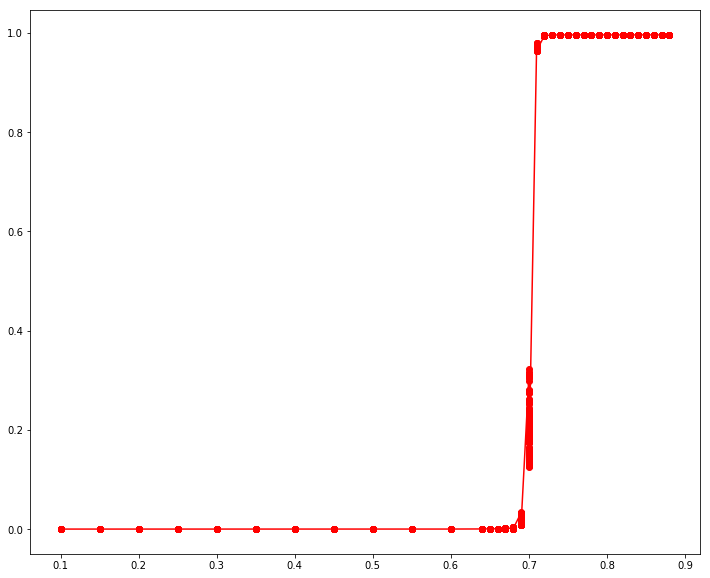

In [38]:
print(np.squeeze(prob))
print(packf)
plt.plot(packf, np.squeeze(prob),'ro-')

In [43]:

prob1 = np.mean(np.reshape(np.squeeze(prob),(36, 100)), axis=1)
pc   = np.mean(np.reshape(packf,(36, 100)), axis=1)
np.savetxt(r'NNprobs.txt', prob1, fmt='%.8f')
np.savetxt(r'NNlabel.txt', pc, fmt='%.8f')

In [42]:
prob1 = np.std(np.reshape(np.squeeze(prob),(36, 100)), axis=1)
pc   = np.std(np.reshape(packf,(36, 100)), axis=1)
np.savetxt(r'NNstd.txt', prob1, fmt='%.8f')
np.savetxt(r'NNlabel.txt', pc, fmt='%.8f')

In [44]:
def load_data2(filename, size):
    '''
    Load coordinates data from file, and combine the x, y cooredates into one row
    filename   -- the file which stores the coordinates
    size       -- size of each configuration (number of particles)
    label_type -- solid/liquid 
    
    '''
    data_df   = pd.read_csv(filename, engine='c')
    n_data    = int(data_df.shape[0]/size)
    
    data_x   = np.array(data_df['x'][:]).reshape(n_data, size)
    data_y   = np.array(data_df['y'][:]).reshape(n_data, size)
    packf    = np.array(data_df['packf'][:]).reshape(n_data,size)
    #print(packf)
    
    dataSet = np.hstack((data_x, data_y, packf))
    

    
    return dataSet

1900
[[ 0.97874224  0.97866827  0.97759807 ...,  0.01829103  0.01920389
   0.01858185]]


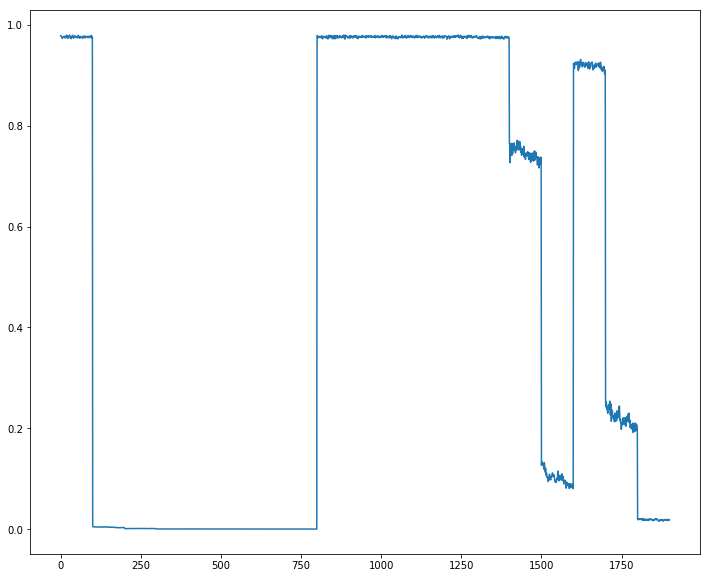

In [105]:

data_df = pd.read_csv("data/configTAllnew.txt",sep=' ', engine='c')

n_data    = int(data_df.shape[0]/size)
    
data_x   = np.array(data_df['x'][:]).reshape(n_data, size) 
data_y   = np.array(data_df['y'][:]).reshape(n_data, size) 
packT    = np.array(data_df['T'][:]).reshape(n_data,size)
dataSet = np.hstack((data_x, data_y, packT))

test_c = dataSet[:, 0:2*size].T
packT  = dataSet[:, 2*size].T

print(n_data)

prediction, prob = predict(test_c[:, :], parameters)

print(prob)
plt.plot(np.squeeze(prob))

In [108]:
prob1 = np.mean(np.reshape(np.squeeze(prob),(19, 100)), axis=1)
probstd = np.std(np.reshape(np.squeeze(prob),(19, 100)), axis=1)
pT    = np.mean(np.reshape(packT,(19, 100)), axis=1)
np.savetxt(r'NNprobsLJ.txt', prob1, fmt='%.8f')
np.savetxt(r'NNprobsStdLJ.txt', probstd, fmt='%.8f')
np.savetxt(r'NNlabelT.txt', pT, fmt='%.8f')

[ 0.97874224  0.97866827  0.97759807 ...,  0.01829103  0.01920389
  0.01858185]
[ 0.1   0.1   0.1  ...,  0.95  0.95  0.95]


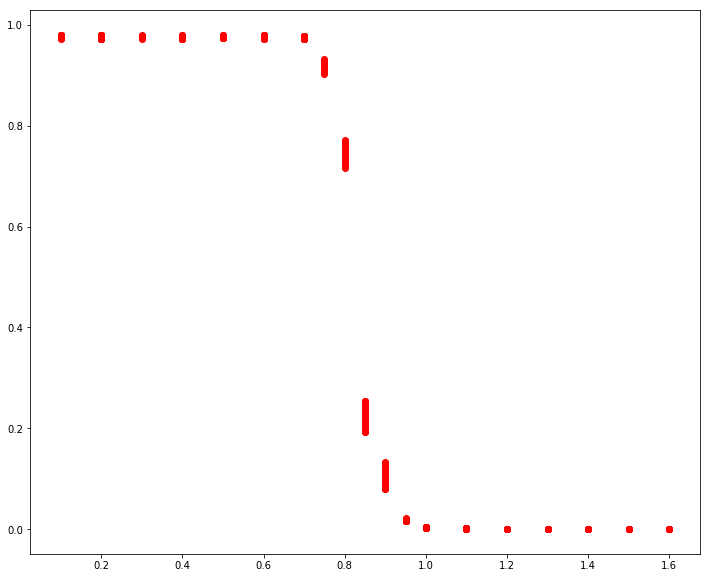

In [109]:
print(np.squeeze(prob))
print(packT*0.1)
plt.plot(packT*0.1, np.squeeze(prob),'ro')